In [1]:
import mne
import numpy as np
from matplotlib import pyplot as plt
from stormdb.access import Query
from pickle import load
from scipy import stats
from mne.datasets import sample
from mne.stats import spatio_temporal_cluster_1samp_test
import os
import os.path as op
import pickle
from copy import deepcopy
from sys import argv
import warnings
import src.group_stats as gs
import importlib
importlib.reload(gs)
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [2]:
os.environ['ETS_TOOLKIT'] = 'qt4'
os.environ['QT_API'] = 'pyqt5'

proj_name = 'MINDLAB2020_MEG-AuditoryPatternRecognition'
wdir = '/projects/' + proj_name + '/scratch/working_memory/'
data_dir = wdir + 'averages/data/'
subs_dir = '/projects/' + proj_name + '/scratch/fs_subjects_dir/'

stats_dir = wdir + 'results/stats/'
figures_dir = wdir + 'results/figures/'

In [3]:
#Get subjects:
qr = Query(proj_name)
sub_codes = qr.get_subjects()

In [4]:
## load data
suffix = 'task_sensor_lf_0.05_hf_None_tstep_0.025_twin_0.05'
sub_Ns = np.arange(11,91) #[2,11,12,13,14,15,16]#np.arange(8) + 1
performance_exc = [55,58,60,73,76,82]
no_source_exc = [30,51,42]
noise_exc = [15]
no_data_exc = [32,33]

exclude = np.array(performance_exc + noise_exc + no_data_exc)
sub_Ns = np.array([s for s in sub_Ns if s not in exclude])
#exclude = np.array([55,60,73,82]) # subjects with low maintenance accuracy
gdata = {}
garray = {}
scount = 0
for sub in sub_Ns:
    sub_code = sub_codes[sub-1]
    try:
        print('loading subject {}'.format(sub_code))
        evkd_fname = op.join(data_dir,sub_code,sub_code + '_patterns_' + suffix + '.p')
        evkd_file = open(evkd_fname,'rb')
        evokeds = pickle.load(evkd_file)
        evkd_file.close()
        scount = scount +1
        for e in evokeds:
            if isinstance(evokeds[e], dict):
                cconds = {e + b: evokeds[e][b] for b in evokeds[e]}
            else:
                cconds = {e: evokeds[e]}
                
            for condname in cconds:
                if scount == 1:
                    gdata[condname] = []
                    garray[condname] = []
                    times_fname = op.join(data_dir,sub_code,sub_code + '_times_' + suffix + '.p')
                    times_file = open(times_fname,'rb')
                    times = pickle.load(times_file)
                    times_file.close()
                cconds[condname].times = times[condname[0:-1]]
                #cconds[condname].tmin = times[condname[0:-1]][0]
                #cconds[condname].tmax = times[condname[0:-1]][-1]
                gdata[condname].append(cconds[condname].data)
                garray[condname].append(cconds[condname])
    except Exception as ex:
        print('could not load subject {}'.format(sub_code))
        print(ex)
        continue
for g in gdata:
    gdata[g] = np.array(gdata[g])

loading subject 0011_U7X
loading subject 0012_VK2
loading subject 0013_NHJ
loading subject 0014_BKO
loading subject 0016_HJF
loading subject 0017_G8O
loading subject 0018_PRG
loading subject 0019_WH8
loading subject 0020_RGF
loading subject 0021_LZW
loading subject 0022_BHR
loading subject 0023_ZPC
loading subject 0024_JSV
loading subject 0025_62P
loading subject 0026_S1H
loading subject 0027_TLV
loading subject 0028_2NK
loading subject 0029_PAX
loading subject 0030_2MP
loading subject 0031_WZD
loading subject 0034_V8Q
loading subject 0035_FTI
loading subject 0036_9EA
loading subject 0037_KPS
loading subject 0038_J7W
loading subject 0039_MLI
loading subject 0040_LDN
loading subject 0041_RSP
loading subject 0042_WOB
loading subject 0043_XKK
loading subject 0044_4QT
loading subject 0045_GVP
loading subject 0046_QXA
loading subject 0047_KXX
loading subject 0048_7BH
loading subject 0049_KFD
loading subject 0050_BBQ
loading subject 0051_NUI
loading subject 0052_GWV
loading subject 0053_BUS


In [5]:
garray['interaction1'] = [mne.combine_evoked([garray['manipulation1'][cs],
                                              garray['maintenance1'][cs]],
                                              weights=[1,-1]) for cs,_ in enumerate(garray['maintenance1'])]
for gdix,gd in enumerate(garray['interaction1']):
    garray['interaction1'][gdix].comment = 'interaction'
gdata['interaction1'] = gdata['manipulation1'] - gdata['maintenance1']
times['interaction'] = times['maintenance']

In [35]:
lix = (times['maintenance'] >= 0) & (times['maintenance'] <= 2)
iix = (times['maintenance'] >= 2) & (times['maintenance'] <= 4)
#print(gdata['maintenance1'][:,:,iix])
gdata['list_vs_im_maintenance'] = gdata['maintenance1'][:,:,iix].mean(axis = 2,keepdims=True) - gdata['maintenance1'][:,:,lix].mean(axis = 2,keepdims=True) 
gdata['list_vs_im_manipulation'] = gdata['manipulation1'][:,:,iix].mean(axis = 2,keepdims=True)  - gdata['manipulation1'][:,:,lix].mean(axis = 2,keepdims=True) 


In [45]:
fix = (times['maintenance'] >= .2) & (times['maintenance'] <= .5)
thix = (times['maintenance'] >= 1.2) & (times['maintenance'] <= 1.5)
#print(gdata['maintenance1'][:,:,iix])
gdata['1st_vs_3rd_maintenance'] = gdata['maintenance1'][:,:,thix].mean(axis = 2,keepdims=True) - gdata['maintenance1'][:,:,fix].mean(axis = 2,keepdims=True) 
gdata['1st_vs_3rd_manipulation'] = gdata['manipulation1'][:,:,thix].mean(axis = 2,keepdims=True)  - gdata['manipulation1'][:,:,fix].mean(axis = 2,keepdims=True) 



In [46]:
grand_avg = {}
for e in garray:
    grand_avg[e] = mne.grand_average(garray[e])
    grand_avg[e].data = np.mean(np.array(gdata[e]),0)
    grand_avg[e].comment = garray[e][0].comment
    grand_avg[e].info['srate'] = 1/.025
    grand_avg[e].times = times[e[0:-1]]

Identifying common channels ...
Identifying common channels ...
Identifying common channels ...


In [47]:
conds = ['maintenance1','manipulation1','interaction1',
        'list_vs_im_maintenance','list_vs_im_manipulation',
        '1st_vs_3rd_maintenance','1st_vs_3rd_manipulation']
stats_results = {}
ch_type = ['mag','grad']
for ct in ch_type:
    stats_results[ct] = {}
    chidx = np.array(mne.pick_types(garray['interaction1'][0].info, meg = ct))
    adjacency,_ = mne.channels.find_ch_adjacency(garray['interaction1'][0].info,ch_type=ct)
    for c in conds:
        X = gdata[c][:,chidx,:]
        stats_results[ct][c] = gs.do_stats(X, method='montecarlo', adjacency=adjacency, FDR_alpha=.025, h0=0,
                                       cluster_alpha = .05, p_threshold = .05, n_permutations=5000)

Reading adjacency matrix for neuromag306mag.
Two sided alpha level: 0.05 - t threshold: 1.9944371113297732
Clustering.
stat_fun(H1): min=-9.224754 max=9.830398
Running initial clustering
Found 62 clusters
Permuting 4999 times...


  0%|          |  : 0/4999 [00:00<?,       ?it/s]

Computing cluster p-values
Done.
Two sided alpha level: 0.05 - t threshold: 1.9944371113297732
Clustering.
stat_fun(H1): min=-8.073517 max=10.571046
Running initial clustering
Found 46 clusters
Permuting 4999 times...


  0%|          |  : 0/4999 [00:00<?,       ?it/s]

Computing cluster p-values
Done.
Two sided alpha level: 0.05 - t threshold: 1.9944371113297732
Clustering.
stat_fun(H1): min=-3.591241 max=4.194249
Running initial clustering
Found 91 clusters
Permuting 4999 times...


  0%|          |  : 0/4999 [00:00<?,       ?it/s]

Computing cluster p-values
Done.
Two sided alpha level: 0.05 - t threshold: 1.9944371113297732
Clustering.
stat_fun(H1): min=-11.643380 max=8.521918
Running initial clustering
Found 2 clusters
Permuting 4999 times...


  0%|          |  : 0/4999 [00:00<?,       ?it/s]

Computing cluster p-values
Done.
Two sided alpha level: 0.05 - t threshold: 1.9944371113297732
Clustering.
stat_fun(H1): min=-7.776805 max=7.377292
Running initial clustering
Found 3 clusters
Permuting 4999 times...


  0%|          |  : 0/4999 [00:00<?,       ?it/s]

Computing cluster p-values
Done.
Two sided alpha level: 0.05 - t threshold: 1.9944371113297732
Clustering.
stat_fun(H1): min=-5.659267 max=6.710274
Running initial clustering
Found 4 clusters
Permuting 4999 times...


  0%|          |  : 0/4999 [00:00<?,       ?it/s]

Computing cluster p-values
Done.
Two sided alpha level: 0.05 - t threshold: 1.9944371113297732
Clustering.
stat_fun(H1): min=-5.732203 max=5.210808
Running initial clustering
Found 3 clusters
Permuting 4999 times...


  0%|          |  : 0/4999 [00:00<?,       ?it/s]

Computing cluster p-values
Done.
Reading adjacency matrix for neuromag306planar.
Two sided alpha level: 0.05 - t threshold: 1.9944371113297732
Clustering.
stat_fun(H1): min=-8.657697 max=8.821265
Running initial clustering
Found 330 clusters
Permuting 4999 times...


  0%|          |  : 0/4999 [00:00<?,       ?it/s]

Computing cluster p-values
Done.
Two sided alpha level: 0.05 - t threshold: 1.9944371113297732
Clustering.
stat_fun(H1): min=-9.540821 max=10.374750
Running initial clustering
Found 328 clusters
Permuting 4999 times...


  0%|          |  : 0/4999 [00:00<?,       ?it/s]

Computing cluster p-values
Done.
Two sided alpha level: 0.05 - t threshold: 1.9944371113297732
Clustering.
stat_fun(H1): min=-4.523227 max=4.449953
Running initial clustering
Found 456 clusters
Permuting 4999 times...


  0%|          |  : 0/4999 [00:00<?,       ?it/s]

Computing cluster p-values
Done.
Two sided alpha level: 0.05 - t threshold: 1.9944371113297732
Clustering.
stat_fun(H1): min=-9.109479 max=8.212755
Running initial clustering
Found 4 clusters
Permuting 4999 times...


  0%|          |  : 0/4999 [00:00<?,       ?it/s]

Computing cluster p-values
Done.
Two sided alpha level: 0.05 - t threshold: 1.9944371113297732
Clustering.
stat_fun(H1): min=-7.201467 max=7.866469
Running initial clustering
Found 7 clusters
Permuting 4999 times...


  0%|          |  : 0/4999 [00:00<?,       ?it/s]

Computing cluster p-values
Done.
Two sided alpha level: 0.05 - t threshold: 1.9944371113297732
Clustering.
stat_fun(H1): min=-6.059000 max=8.288665
Running initial clustering
Found 10 clusters
Permuting 4999 times...


  0%|          |  : 0/4999 [00:00<?,       ?it/s]

Computing cluster p-values
Done.
Two sided alpha level: 0.05 - t threshold: 1.9944371113297732
Clustering.
stat_fun(H1): min=-4.625215 max=7.590226
Running initial clustering
Found 17 clusters
Permuting 4999 times...


  0%|          |  : 0/4999 [00:00<?,       ?it/s]

Computing cluster p-values
Done.



############### mag ################

############# encoding1 ################

maintenance1


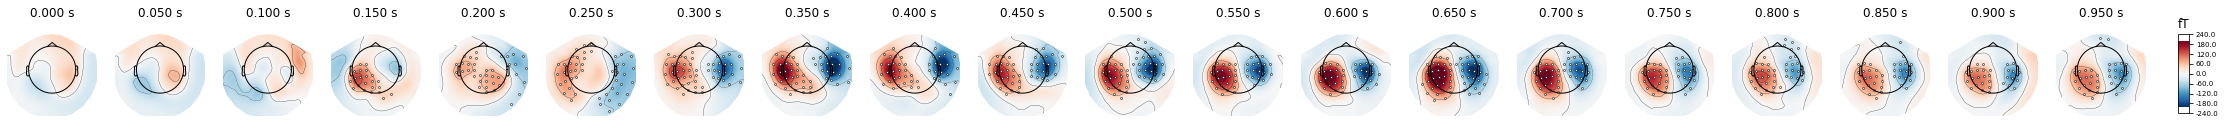

manipulation1


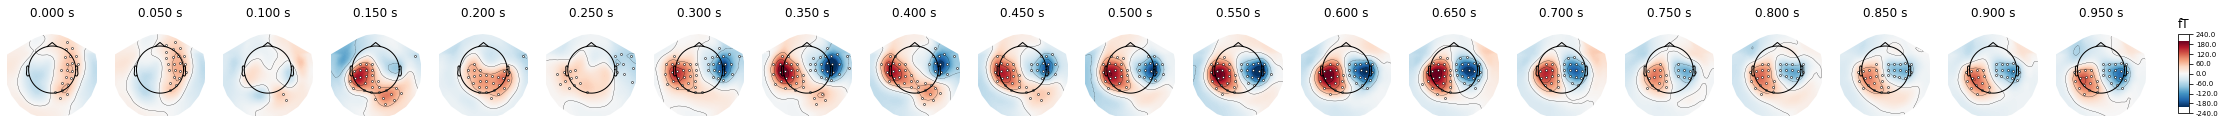

interaction1


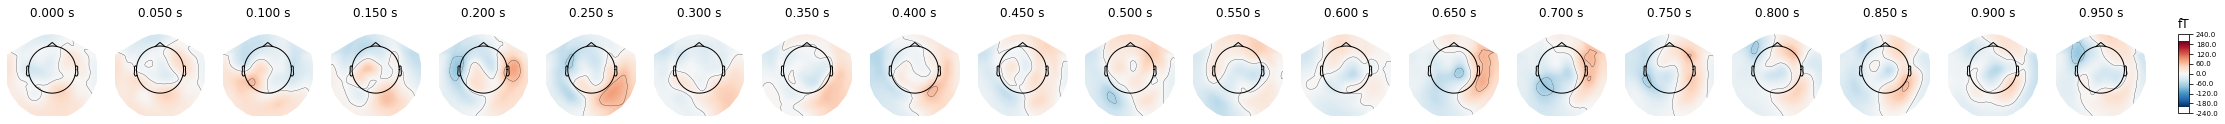

############# encoding2 ################

maintenance1


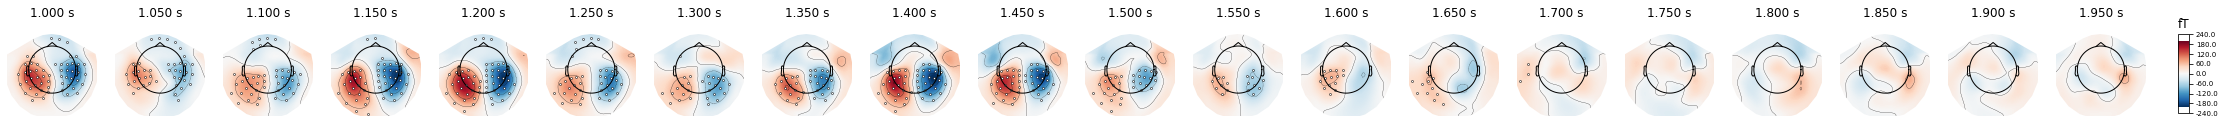

manipulation1


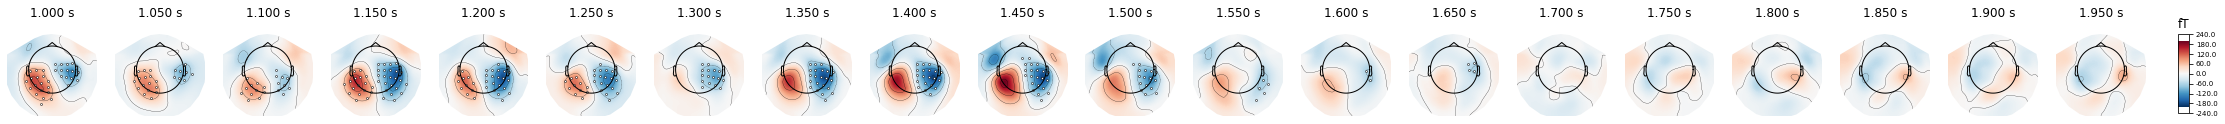

interaction1


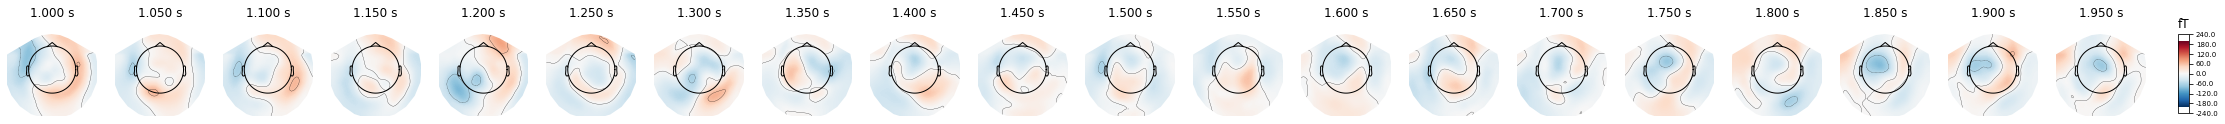

############# delay1 ################

maintenance1


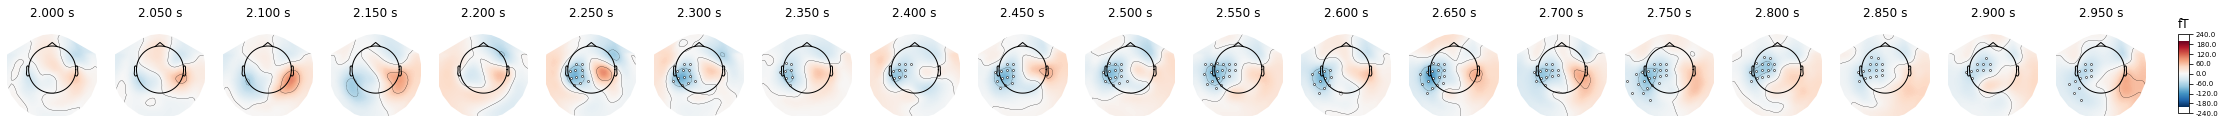

manipulation1


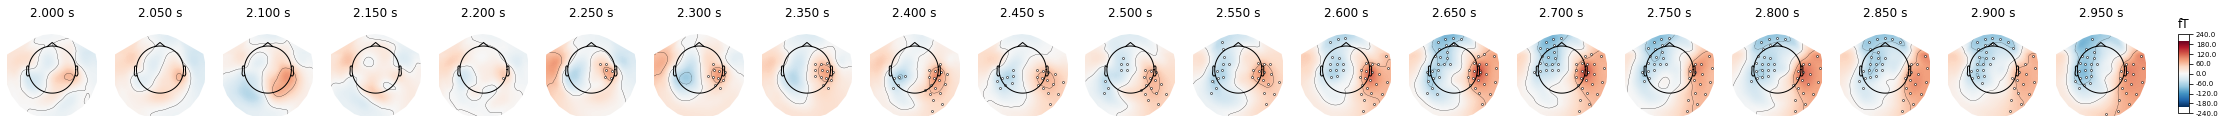

interaction1


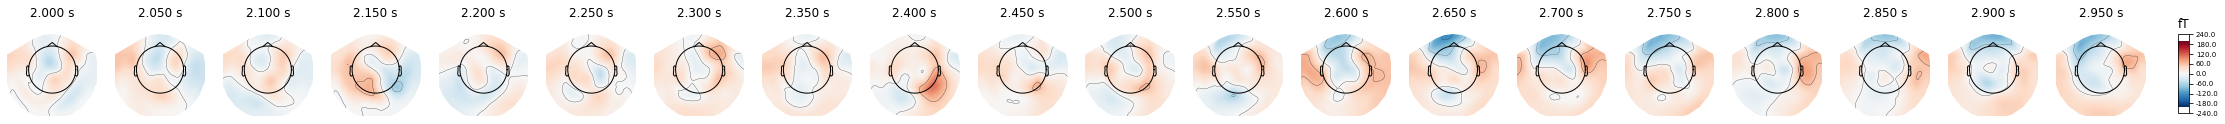

############# delay2 ################

maintenance1


/tmp/ipykernel_5639/4188956520.py:17: RuntimeWarning: tmax is not in Evoked time interval. tmax is set to evoked.tmax (3.975 sec)
  cERF = cERF.pick_types(meg=cht).crop(tmin=tmin, tmax=tmax)


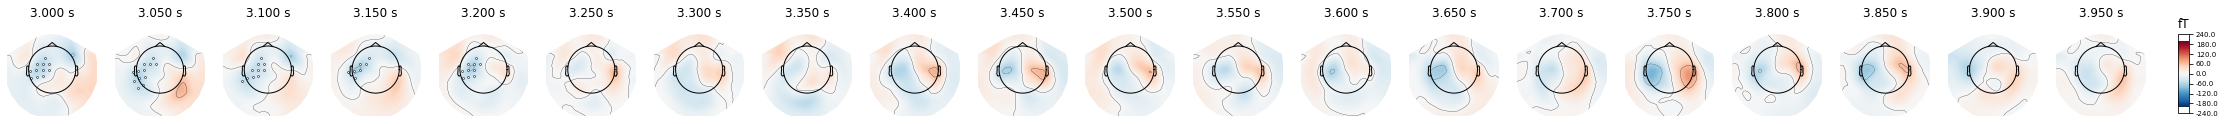

/tmp/ipykernel_5639/4188956520.py:17: RuntimeWarning: tmax is not in Evoked time interval. tmax is set to evoked.tmax (3.975 sec)
  cERF = cERF.pick_types(meg=cht).crop(tmin=tmin, tmax=tmax)


manipulation1


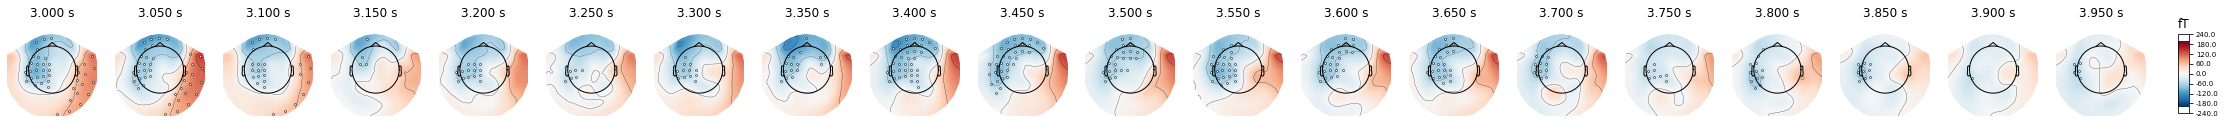

/tmp/ipykernel_5639/4188956520.py:17: RuntimeWarning: tmax is not in Evoked time interval. tmax is set to evoked.tmax (3.975 sec)
  cERF = cERF.pick_types(meg=cht).crop(tmin=tmin, tmax=tmax)


interaction1


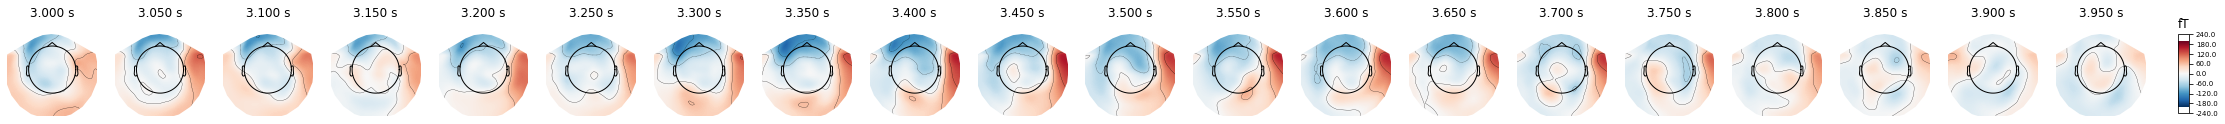


############### grad ################

############# encoding1 ################

maintenance1


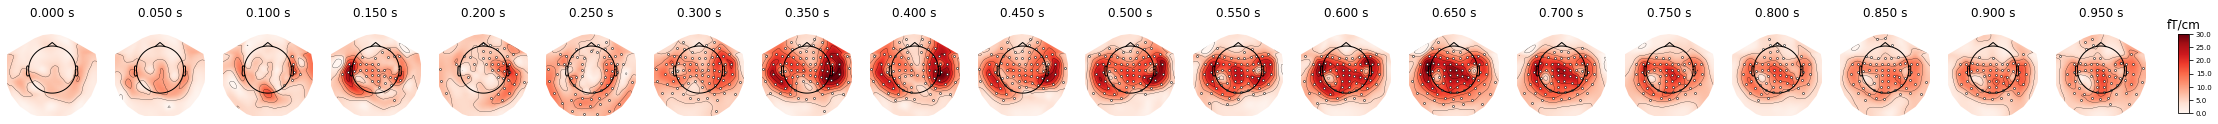

manipulation1


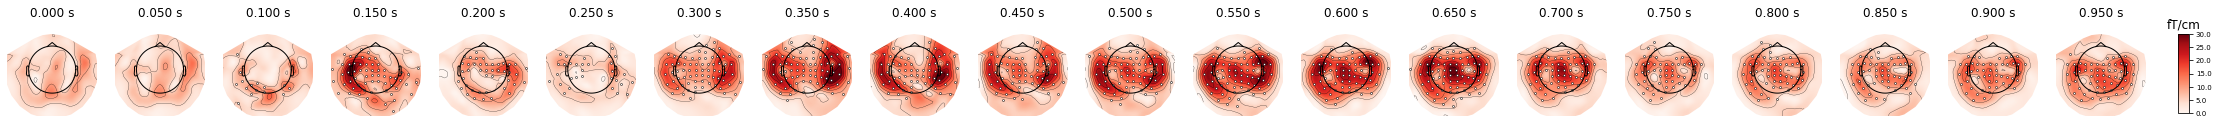

interaction1


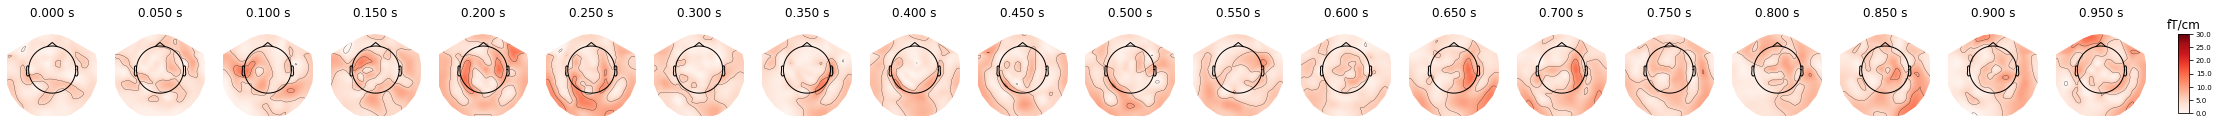

############# encoding2 ################

maintenance1


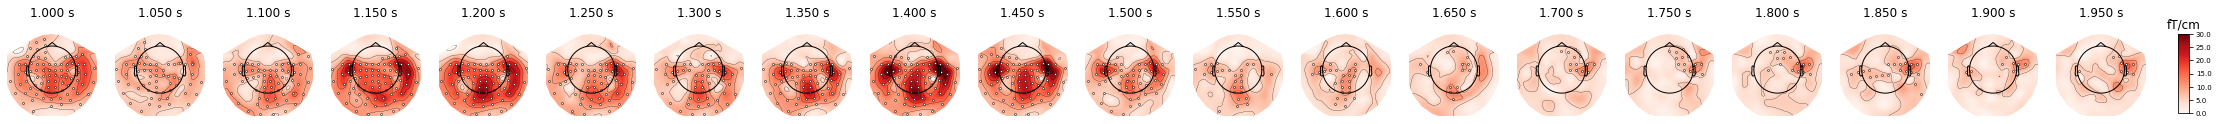

manipulation1


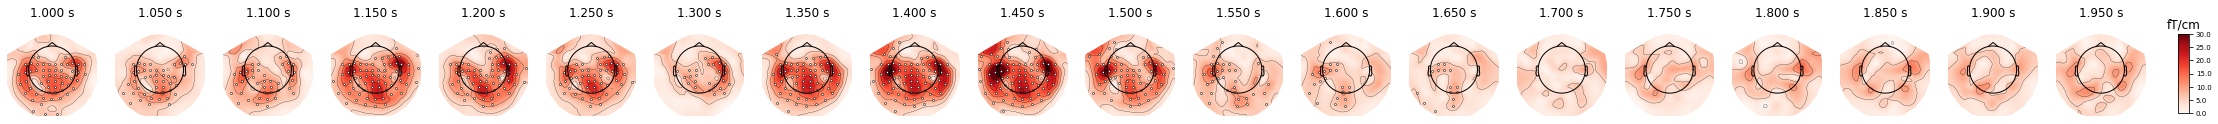

interaction1


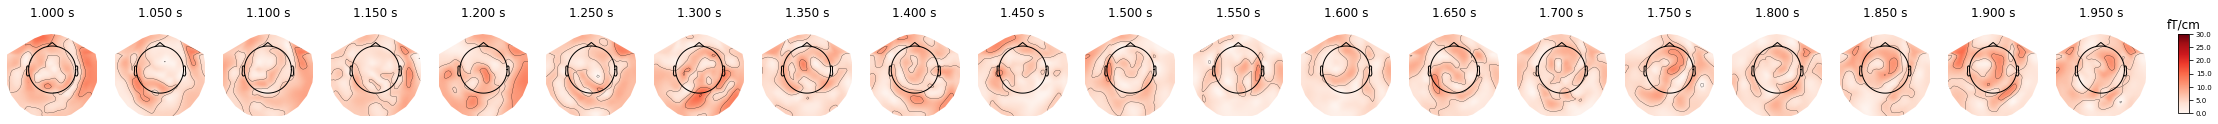

############# delay1 ################

maintenance1


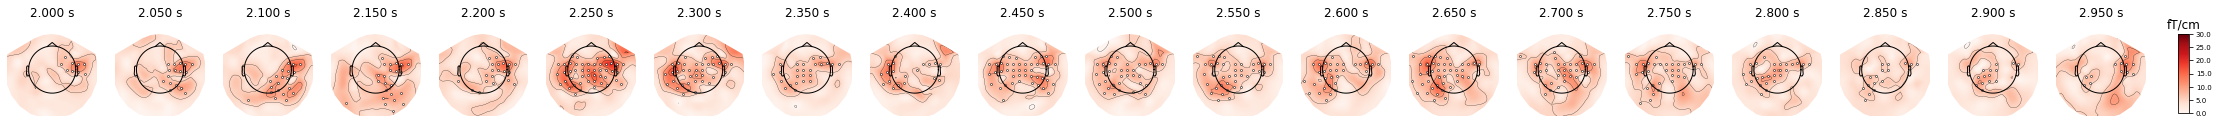

manipulation1


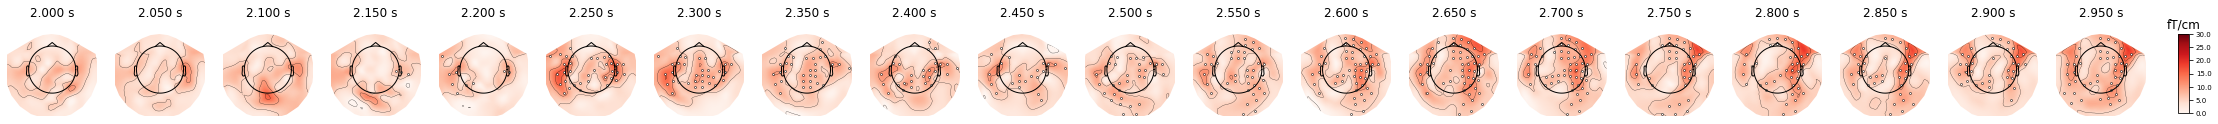

interaction1


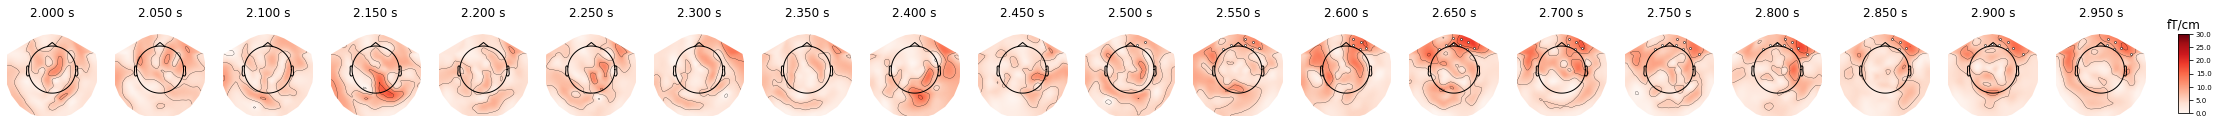

############# delay2 ################

maintenance1


/tmp/ipykernel_5639/4188956520.py:17: RuntimeWarning: tmax is not in Evoked time interval. tmax is set to evoked.tmax (3.975 sec)
  cERF = cERF.pick_types(meg=cht).crop(tmin=tmin, tmax=tmax)


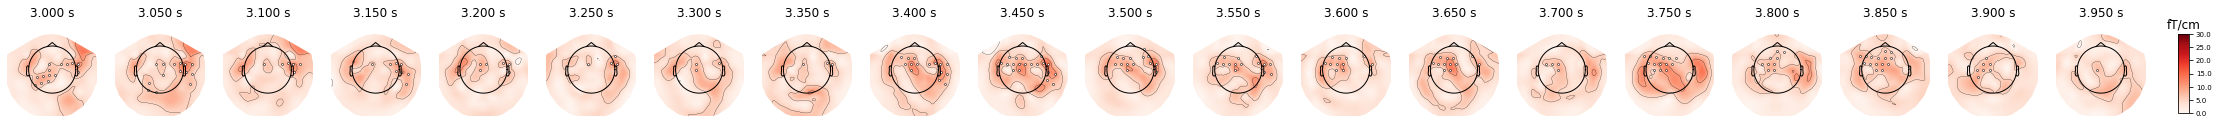

/tmp/ipykernel_5639/4188956520.py:17: RuntimeWarning: tmax is not in Evoked time interval. tmax is set to evoked.tmax (3.975 sec)
  cERF = cERF.pick_types(meg=cht).crop(tmin=tmin, tmax=tmax)


manipulation1


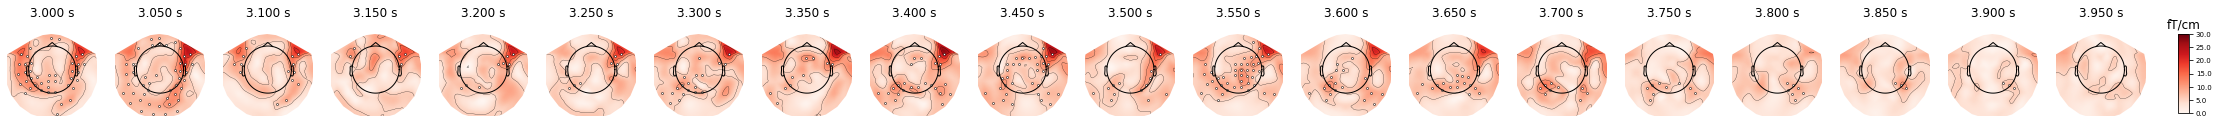

/tmp/ipykernel_5639/4188956520.py:17: RuntimeWarning: tmax is not in Evoked time interval. tmax is set to evoked.tmax (3.975 sec)
  cERF = cERF.pick_types(meg=cht).crop(tmin=tmin, tmax=tmax)


interaction1


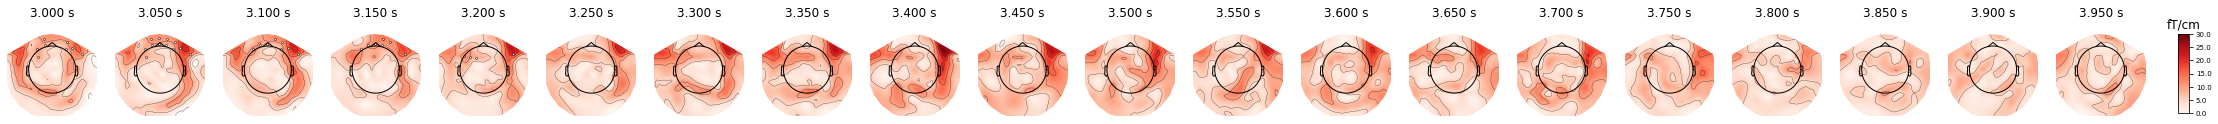

In [8]:
#periods = {'encoding': [0,2], 'delay': [2,3.975]}#, 'retrieval': [4,6]}
periods = {'encoding1': [0,1],'encoding2': [1,2], 'delay1': [2,3], 'delay2': [3,3.975]}
tstep = .05
#periods = {'all': [0,3.91]}#, 'delay': [2,3.975]}
ch_type = ['mag','grad']
vlims = {'mag': [-200,200],'grad': [0,30]}
#conds = ['melody','block','interaction']
for cht in ch_type:
    print('\n############### {} ################\n'.format(cht))
    for p in periods:
        print('############# {} ################\n'.format(p))
        for c in stats_results[cht]:
            tmin = periods[p][0]
            tmax = periods[p][1]
            cERF = grand_avg[c].copy()
            tidx = np.where([x and y for x,y in zip(cERF.times >= tmin, cERF.times <= tmax)])[0]
            cERF = cERF.pick_types(meg=cht).crop(tmin=tmin, tmax=tmax)

#             cdata = stats_results[cht][c]['tvals'].copy()
#             cdata = cdata[:,tidx]
            cdata =  cERF.data
            cmask = stats_results[cht][c]['mask'].copy()
            #cmask = stats_results[cht][c]['pvals'] < .001
            cmask = cmask[:,tidx]
            cERF.data = cdata#*cmask
            plot_times = np.arange(tmin,tmax,tstep)
            
            print(c)
            cERF.plot_topomap(times=plot_times, mask=cmask,average=tstep,
                               vmin = vlims[cht][0], vmax = vlims[cht][1], sensors=False)
            plt.show()


############### mag ################

############# L1 ################

############# maintenance1 ################

maintenance1


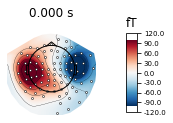

############# manipulation1 ################

manipulation1


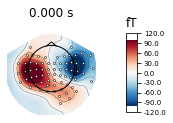

############# interaction1 ################

interaction1


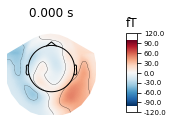

############# L2 ################

############# maintenance1 ################

maintenance1


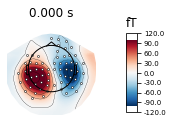

############# manipulation1 ################

manipulation1


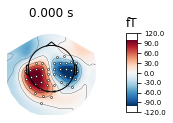

############# interaction1 ################

interaction1


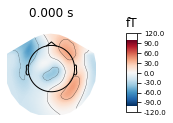

############# L3 ################

############# maintenance1 ################

maintenance1


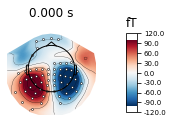

############# manipulation1 ################

manipulation1


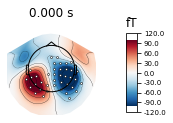

############# interaction1 ################

interaction1


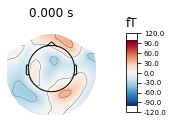

############# I1 ################

############# maintenance1 ################

maintenance1


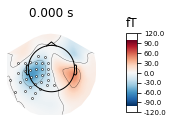

############# manipulation1 ################

manipulation1


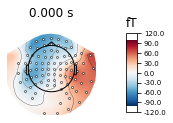

############# interaction1 ################

interaction1


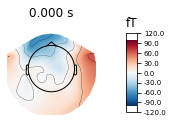

############# I2 ################

############# maintenance1 ################

maintenance1


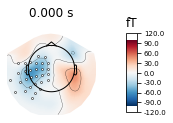

############# manipulation1 ################

manipulation1


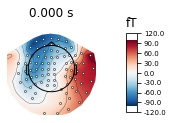

############# interaction1 ################

interaction1


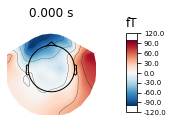


############### grad ################

############# L1 ################

############# maintenance1 ################

maintenance1


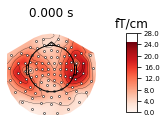

############# manipulation1 ################

manipulation1


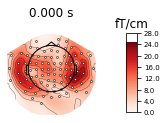

############# interaction1 ################

interaction1


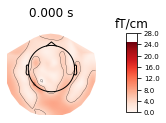

############# L2 ################

############# maintenance1 ################

maintenance1


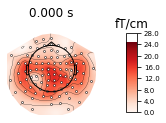

############# manipulation1 ################

manipulation1


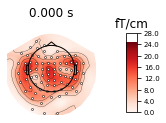

############# interaction1 ################

interaction1


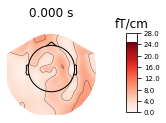

############# L3 ################

############# maintenance1 ################

maintenance1


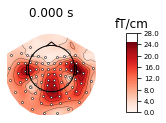

############# manipulation1 ################

manipulation1


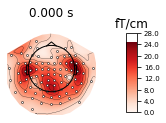

############# interaction1 ################

interaction1


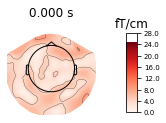

############# I1 ################

############# maintenance1 ################

maintenance1


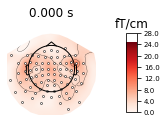

############# manipulation1 ################

manipulation1


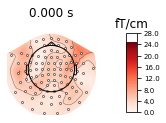

############# interaction1 ################

interaction1


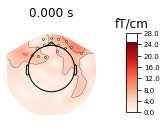

############# I2 ################

############# maintenance1 ################

maintenance1


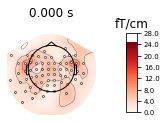

############# manipulation1 ################

manipulation1


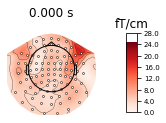

############# interaction1 ################

interaction1


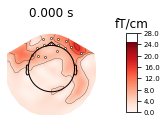

In [38]:
#periods = {'encoding': [0,2], 'delay': [2,3.975]}#, 'retrieval': [4,6]}
# periods = {'encoding': {'maintenance1': [.2,.4,1.2,1.4],
#                         'manipulation1': [.2,.4,1.2,1.4],
#                         'interaction1': []},
#              'delay': {'maintenance1': [3.18],
#                         'manipulation1': [3.08],
#                         'interaction1': [3.02]}}
periods = {#'all':[0, 4],
           #'list_vs_im': [0,4],
           'L1': [.2,.5],
           'L2': [.7,1.],
           'L3': [1.2,1.5],
           'I1': [2,4],
           'I2': [2.5,3.5]
           }#,'retrieval': [4,6.25]}{'all': [0.,4]}#
#periods = {'all': [0,3.91]}#, 'delay': [2,3.975]}
ch_type = ['mag','grad']
vlims = {'mag': [-100,100],'grad': [0,25]}
conds = ['maintenance1','manipulation1','interaction1']

for cht in ch_type:
    print('\n############### {} ################\n'.format(cht))
    for p in periods:
        print('############# {} ################\n'.format(p))
        for c in conds:#stats_results[cht]:
            print('############# {} ################\n'.format(c))
            #for tix, t in enumerate(periods[p][c]):
            #tstep = tsteps[p][c][tix]
            cERF = grand_avg[c].copy()
            #
            cERF = cERF.pick_types(meg=cht)
            tmin, tmax = periods[p]
            tidx = np.where([x and y for x,y in zip(cERF.times >= tmin, cERF.times <= tmax)])[0]
            cdata = stats_results[cht][c]['data_mean'].copy()
            cdata = cdata[:,tidx].mean(axis=1,keepdims=True)
            cERF.times=np.array([0])
            #cdata = cERF.data
            cmask = stats_results[cht][c]['mask'].copy()[:,tidx].astype(int).mean(axis=1,keepdims=True) > 0
            #cmask = stats_results[cht][c]['pvals'] < .001
            #cmask = cmask[:,tidx]
            cERF.data = cdata#*cmask
            #plot_times = np.arange(tmin,tmax,tstep)

            print(c)
            cfig = cERF.plot_topomap(mask=cmask, times = 0, vmin = vlims[cht][0], vmax = vlims[cht][1], sensors=False)
            cfig.savefig('{}patterns_sensor_{}_{}_topoplot_{}.pdf'.format(figures_dir,c,p,cht))
            plt.show()


mag list_vs_im_maintenance


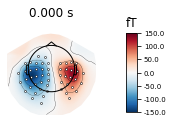

grad list_vs_im_maintenance


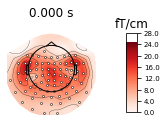

mag list_vs_im_manipulation


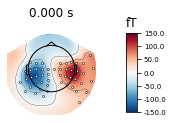

grad list_vs_im_manipulation


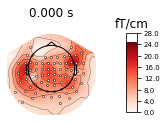

mag 1st_vs_3rd_maintenance


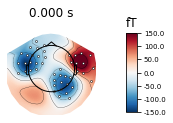

grad 1st_vs_3rd_maintenance


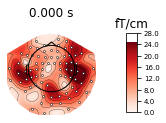

mag 1st_vs_3rd_manipulation


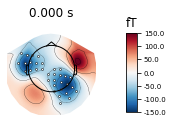

grad 1st_vs_3rd_manipulation


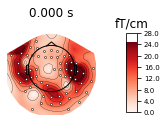

In [48]:
# Plot listen vs imagine. 

conds = ['list_vs_im_maintenance','list_vs_im_manipulation',
         '1st_vs_3rd_maintenance','1st_vs_3rd_manipulation' ]
ch_type = ['mag','grad']
vlims = {'mag': [-150,150],'grad': [0,25]}
for c in conds:
    for cht in ch_type:
        print(cht,c)
        cERF = grand_avg['maintenance1'].copy()
        cERF = cERF.pick_types(meg=cht)
        #print(stats_results[cht].keys())

        cdata = stats_results[cht][c]['data_mean'].copy()
        cERF.times=np.array([0])
        #cdata = cERF.data
        cmask = stats_results[cht][c]['mask']
        #cmask = stats_results[cht][c]['pvals'] < .001
        #cmask = cmask[:,tidx]
        cERF.data = cdata#*cmask
        cfig=cERF.plot_topomap(mask=cmask, times = 0,vmin = vlims[cht][0], vmax = vlims[cht][1], sensors=False)
        cfig.savefig('{}patterns_sensor_{}_{}.pdf'.format(figures_dir,c,cht))
        plt.show()

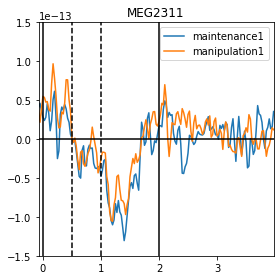

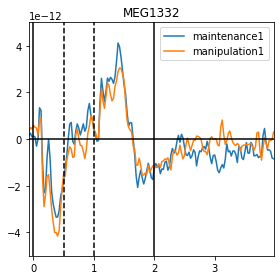

In [59]:
conds = ['maintenance1','manipulation1']
ch_type = ['mag','grad']
ncols = 1
vlims = {'mag': [-150e-15,150e-15],'grad': [-50e-13,50e-13]}
# channel_lists = {'mag': grand_avg['maintenance1'].copy().pick_types('mag').info['ch_names'], 
#                  'grad': grand_avg['maintenance1'].copy().pick_types('grad').info['ch_names']}

channel_lists = {'mag': ['MEG2311'], 'grad': ['MEG1332']}
for cht in ch_type:
        channels = channel_lists[cht]
        nrows = int(np.ceil(len(channels)/ncols))
        cfig, ax = plt.subplots(nrows=nrows,ncols = ncols,
                                figsize = (ncols*4,nrows*4) )
                        
        for cchix, cch in enumerate(channels):
                if nrows > 1:
                   cax = ax[cchix//ncols,cchix%ncols]
                elif ncols > 1:
                   cax = ax[cchix]
                else:
                   cax = ax

                for c in conds:       
                        cERF = grand_avg[c].copy().pick_channels([cch])
                        cax.plot(cERF.times,np.squeeze(cERF.data),label=c)
                cax.set_title(cch)
                cax.axhline(0,color='k')
                cax.axvline(0,color='k')
                cax.axvline(.5,color='k',linestyle='--')
                cax.axvline(1,color='k',linestyle='--')
                cax.axvline(2,color='k')
                cax.set_ylim(vlims[cht][0],vlims[cht][1])
                cax.set_xlim(cERF.times[0],cERF.times[-1])
                plt.legend()      
        plt.tight_layout()
        cfig.savefig('{}patterns_sensor_1st_vs_3rd_{}.pdf'.format(figures_dir,cht))
        cfig.show()

In [7]:
adjacency = mne.spatial_src_adjacency(src_sample)

-- number of adjacent vertices : 14343


In [8]:
stats_results = {}
for cd in all_data:
    stats_results[cd] = do_stats(all_data[cd], method='FDR', adjacency=adjacency)


Performing FDR correction
.

Performing FDR correction
.

Performing FDR correction
.

Performing FDR correction
.


-0.25
main_delay (-0.25 0.0):
Showing: t = -0.112 s, (40.0, -45.0, -30.0) mm, [24, 14, 9] vox, 12069 vertex
Using control points [1.31442834 1.94268179 4.41841403]


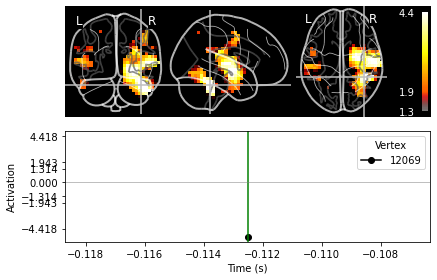

main_delay (0.0 0.25):
Showing: t = 0.138 s, (60.0, -10.0, 10.0) mm, [28, 21, 17] vox, 22600 vertex
Using control points [2.16108558 2.63797061 4.56848219]


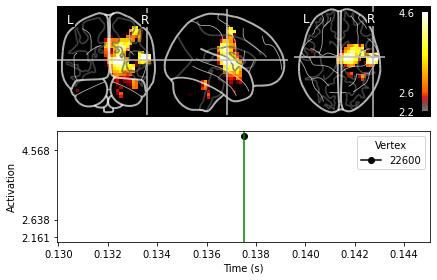

main_delay (0.25 0.5):
Showing: t = 0.388 s, (10.0, -10.0, 5.0) mm, [18, 21, 16] vox, 21303 vertex
Using control points [3.1355981  3.61563902 5.15882928]


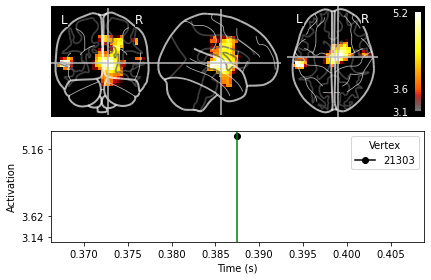

main_delay (0.5 0.75):
Showing: t = 0.637 s, (5.0, -15.0, 5.0) mm, [17, 20, 16] vox, 21269 vertex
Using control points [4.53205976 5.06230163 7.89458519]


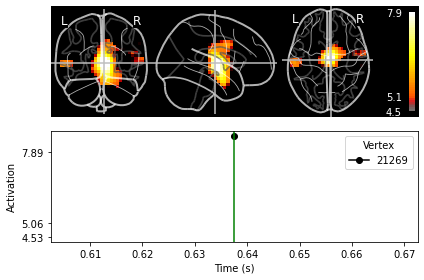

main_delay (0.75 1.0):
Showing: t = 0.887 s, (10.0, -15.0, 5.0) mm, [18, 20, 16] vox, 21270 vertex
Using control points [3.29677162 3.99611784 6.98763808]


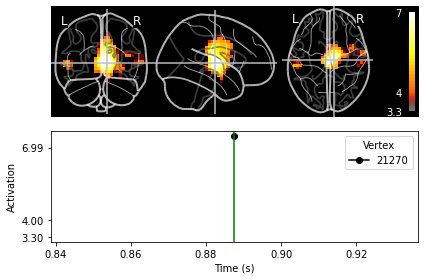

main_delay (1.0 1.25):
Showing: t = 1.137 s, (0.0, -10.0, 5.0) mm, [16, 21, 16] vox, 21301 vertex
Using control points [2.47328175 3.19944007 6.54799153]


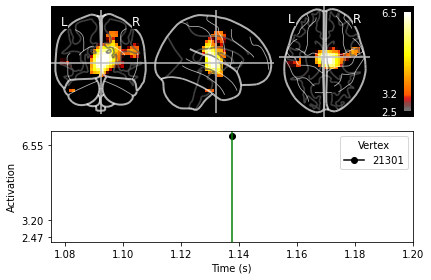

main_delay (1.25 1.5):
Showing: t = 1.387 s, (0.0, -10.0, 10.0) mm, [16, 21, 17] vox, 22588 vertex
Using control points [3.11283733 3.79341784 6.5487719 ]


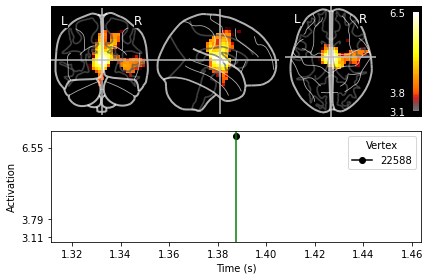

main_delay (1.5 1.75):
Showing: t = 1.637 s, (0.0, -15.0, 5.0) mm, [16, 20, 16] vox, 21268 vertex
Using control points [1.57626397 2.24821791 4.95465961]


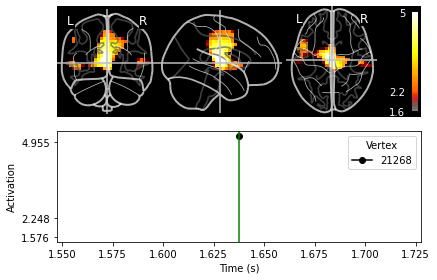

-0.25
inv_delay (-0.25 0.0):
Showing: t = -0.112 s, (65.0, -30.0, 30.0) mm, [29, 17, 21] vox, 27617 vertex
Using control points [1.09703678 1.75967079 4.07444446]


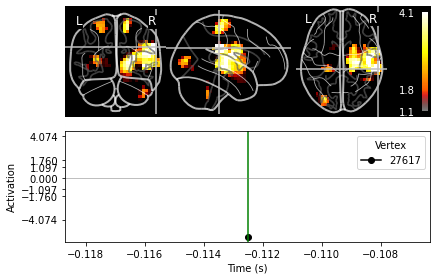

inv_delay (0.0 0.25):
Showing: t = 0.138 s, (15.0, -15.0, 10.0) mm, [19, 20, 17] vox, 22558 vertex
Using control points [1.27664364 1.71007528 4.11383425]


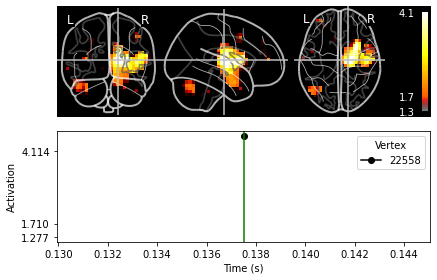

inv_delay (0.25 0.5):
Showing: t = 0.388 s, (-65.0, -20.0, 5.0) mm, [3, 19, 16] vox, 21222 vertex
Using control points [2.05561147 2.6079875  4.50184416]


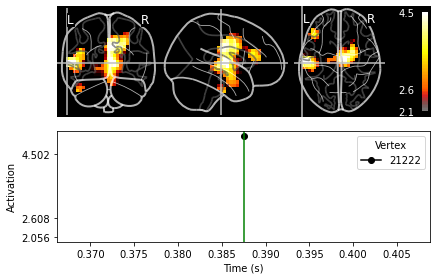

inv_delay (0.5 0.75):
Showing: t = 0.637 s, (-65.0, -20.0, 5.0) mm, [3, 19, 16] vox, 21222 vertex
Using control points [3.32896027 3.8775567  5.56157471]


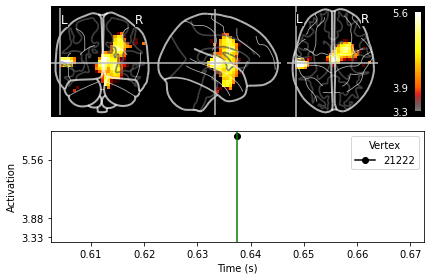

inv_delay (0.75 1.0):
Showing: t = 0.887 s, (5.0, -10.0, 5.0) mm, [17, 21, 16] vox, 21302 vertex
Using control points [3.65127801 4.23276731 5.69943376]


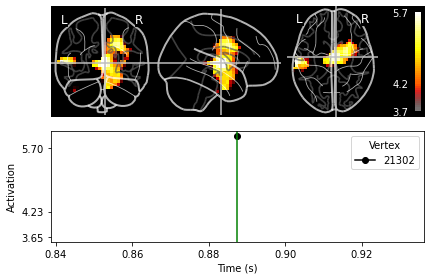

inv_delay (1.0 1.25):
Showing: t = 1.137 s, (5.0, -15.0, 5.0) mm, [17, 20, 16] vox, 21269 vertex
Using control points [2.87906031 3.6040629  6.25652796]


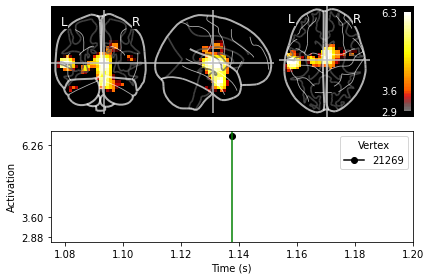

inv_delay (1.25 1.5):
Showing: t = 1.387 s, (0.0, -20.0, 15.0) mm, [16, 19, 18] vox, 23809 vertex
Using control points [2.1149414  2.88691464 5.65036706]


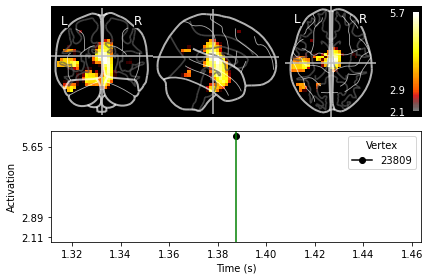

inv_delay (1.5 1.75):
Showing: t = 1.637 s, (0.0, -20.0, 10.0) mm, [16, 19, 17] vox, 22522 vertex
Using control points [1.16723633 1.70939843 5.58021027]


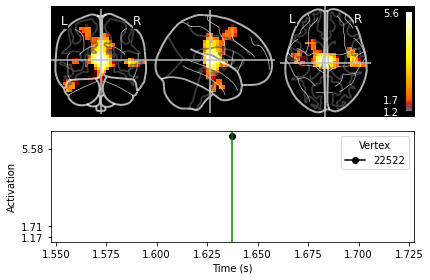

-0.25
main_fmel (-0.25 0.0):
Showing: t = -0.112 s, (5.0, -0.0, 40.0) mm, [17, 23, 23] vox, 30377 vertex
Using control points [2.53850577 3.3141406  5.15712963]


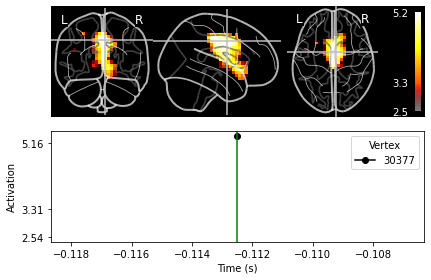

main_fmel (0.0 0.25):
Showing: t = 0.138 s, (10.0, 35.0, -15.0) mm, [18, 30, 12] vox, 16452 vertex
Using control points [1.33631224 1.44741835 2.01677783]


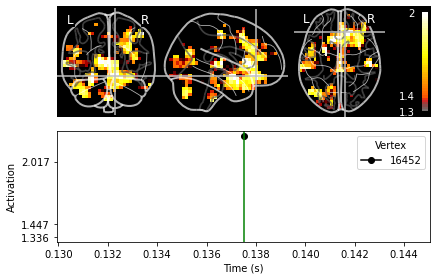

main_fmel (0.25 0.5):
Showing: t = 0.388 s, (-5.0, -15.0, 30.0) mm, [15, 20, 21] vox, 27702 vertex
Using control points [2.73958013 3.26406806 5.50123454]


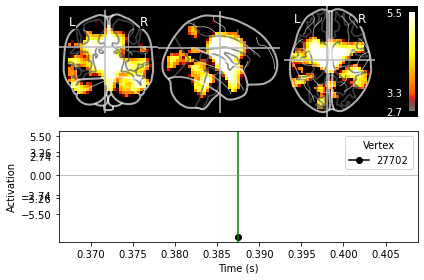

main_fmel (0.5 0.75):
Showing: t = 0.637 s, (-5.0, -15.0, 10.0) mm, [15, 20, 17] vox, 22554 vertex
Using control points [1.16698518 1.50955448 3.98951764]


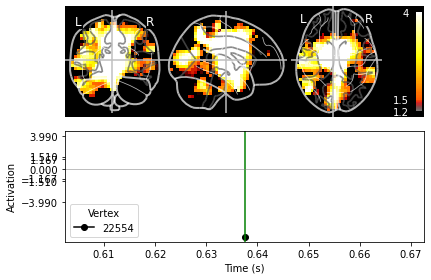

main_fmel (0.75 1.0):
Showing: t = 0.887 s, (-5.0, -10.0, 15.0) mm, [15, 21, 18] vox, 23874 vertex
Using control points [2.49002504 2.93869378 4.45595279]


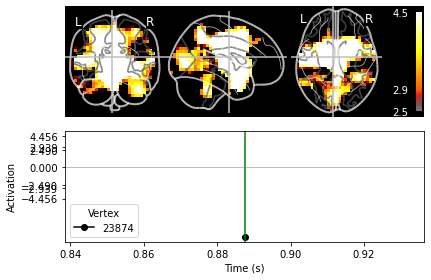

main_fmel (1.0 1.25):
Showing: t = 1.137 s, (-5.0, -10.0, 10.0) mm, [15, 21, 17] vox, 22587 vertex
Using control points [1.27993199 1.63058063 2.81213112]


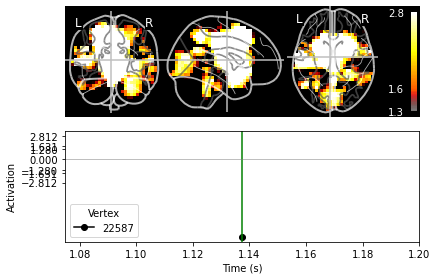

main_fmel (1.25 1.5):
Showing: t = 1.350 s, (0.0, -5.0, 5.0) mm, [16, 22, 16] vox, 21334 vertex
Using control points [1.33321333 2.02541989 4.06052141]


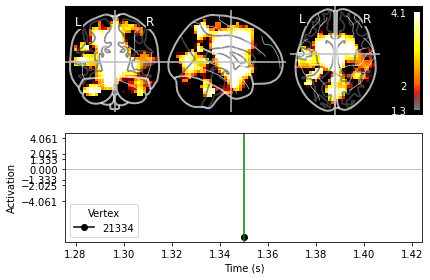

main_fmel (1.5 1.75):


ValueError: No samples remain when using tmin=1.5 and tmax=1.75 (original time bounds are [-0.25, 1.425])

In [15]:
crop_times = np.arange(-0.25,2,0.25)
for p in stats_results:
    print(grand_avg[p].tmin)
    for tidx, t in enumerate(crop_times):        
        if tidx < (len(crop_times) - 1):
            t2 = crop_times[tidx + 1]
            print('{} ({} {}):'.format(p, t, t2) )
            cdata = grand_avg[p].copy()
            cdata.data = stats_results[p]['tvals'].T * stats_results[p]['mask'].T 
            cdata.copy().crop(t,t2).mean().plot(src = src_sample, subjects_dir = subs_dir, mode = 'glass_brain',#'glass_brain',#'glass_brain',#initial_time = 1.75,
                              initial_pos = None)#[.007,.05,.023])

In [ ]:
for p in stats_results:
    print(p)
    cdata = grand_avg[p].copy()
    cdata.data = stats_results[p]['tvals'] * stats_results[p]['mask'] 
    cdata.mean().plot(src = src_sample, subjects_dir = subs_dir, mode = 'glass_brain')#'glass_brain')#[.007,.05,.023])    

In [ ]:
crop_times = np.arange(-0.5,2.5,0.5)
for p in grand_avg:
    print(grand_avg[p].tmin)
    for tidx, t in enumerate(crop_times):        
        if tidx < (len(crop_times) - 1):
            t2 = crop_times[tidx + 1]
            print('{} ({} {}):'.format(p, t, t2) )
            grand_avg[p].copy().crop(t,t2).mean().plot(src = src_sample, subjects_dir = subs_dir, mode = 'stat_map',#'glass_brain',#'glass_brain',#initial_time = 1.75,
                              initial_pos = None)#[.007,.05,.023])

main_delay
Fixing initial position: [5.0, -5.0, 5.0] mm
Showing: t = 0.850 s, (5.0, -5.0, 5.0) mm, [17, 22, 16] vox, 21335 vertex


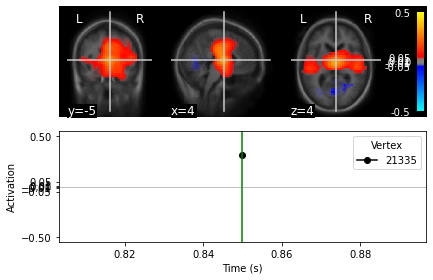

inv_delay
Fixing initial position: [5.0, -5.0, 5.0] mm
Showing: t = 0.850 s, (5.0, -5.0, 5.0) mm, [17, 22, 16] vox, 21335 vertex


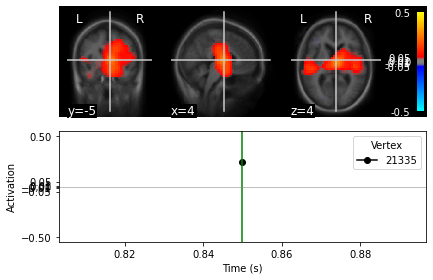

main_fmel
Fixing initial position: [5.0, -5.0, 5.0] mm
Showing: t = 0.600 s, (5.0, -5.0, 5.0) mm, [17, 22, 16] vox, 21335 vertex


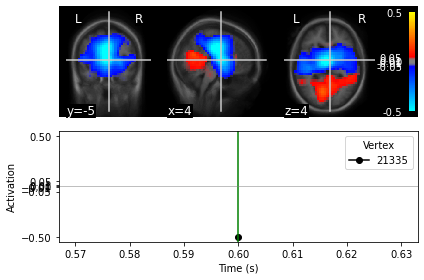

inv_fmel
Fixing initial position: [5.0, -5.0, 5.0] mm
Showing: t = 0.600 s, (5.0, -5.0, 5.0) mm, [17, 22, 16] vox, 21335 vertex


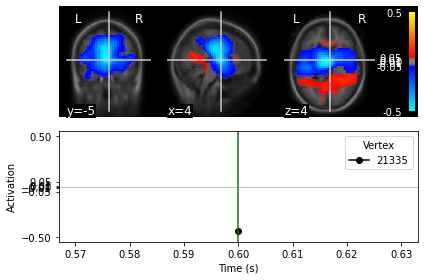

In [12]:
coords = [[.005,-.005,.005]]
for p in grand_avg:
    print(p)
    cdata = grand_avg[p].copy()
    cdata.data = stats_results[p]['data_mean'].T * stats_results[p]['mask'].T 
    for c in coords:
        cdata.mean().plot(src = src_sample, subjects_dir = subs_dir, mode = 'stat_map', initial_pos=c,
                                clim = {'kind': 'value', 'pos_lims': [0.01,0.05,0.5]})#'glass_brain')#[.007,.05,.023])
    

In [ ]:
ts = [0.3,1.3]
for p in grand_avg:
    for t in ts:
        print(grand_avg[p].tmin)
        print('{} ({}):'.format(p, t) )
        cdata = grand_avg[p].copy()
        cdata.data = stats_results[p]['data_mean'].T * stats_results[p]['mask'].T 
        cdata.plot(src = src_sample, subjects_dir = subs_dir, mode = 'stat_map',#initial_pos=[.005,-.005,.005], #stat_map',#'glass_brain',#'glass_brain',#initial_time = 1.75,
                                  initial_time = t, clim = {'kind': 'value', 'pos_lims': [0.001,0.05,0.6]})#[.007,.05,.023])

In [9]:
## Plot regions of interest.
labels = mne.get_volume_labels_from_aseg(label_file)

In [10]:
for l in labels:
    print(l)

Unknown
Left-Cerebral-White-Matter
Left-Lateral-Ventricle
Left-Inf-Lat-Vent
Left-Cerebellum-White-Matter
Left-Cerebellum-Cortex
Left-Thalamus-Proper
Left-Caudate
Left-Putamen
Left-Pallidum
3rd-Ventricle
4th-Ventricle
Brain-Stem
Left-Hippocampus
Left-Amygdala
CSF
Left-Accumbens-area
Left-VentralDC
Left-vessel
Left-choroid-plexus
Right-Cerebral-White-Matter
Right-Lateral-Ventricle
Right-Inf-Lat-Vent
Right-Cerebellum-White-Matter
Right-Cerebellum-Cortex
Right-Thalamus-Proper
Right-Caudate
Right-Putamen
Right-Pallidum
Right-Hippocampus
Right-Amygdala
Right-Accumbens-area
Right-VentralDC
Right-vessel
Right-choroid-plexus
WM-hypointensities
Optic-Chiasm
CC_Posterior
CC_Mid_Posterior
CC_Central
CC_Mid_Anterior
CC_Anterior
ctx_lh_G_and_S_frontomargin
ctx_lh_G_and_S_occipital_inf
ctx_lh_G_and_S_paracentral
ctx_lh_G_and_S_subcentral
ctx_lh_G_and_S_transv_frontopol
ctx_lh_G_and_S_cingul-Ant
ctx_lh_G_and_S_cingul-Mid-Ant
ctx_lh_G_and_S_cingul-Mid-Post
ctx_lh_G_cingul-Post-dorsal
ctx_lh_G_cingul-Po

In [25]:
clabels = ['Left-Thalamus-Proper',
           'Right-Thalamus-Proper',
           #'Left-Caudate',
           #'Right-Caudate',
           'ctx_lh_G_and_S_cingul-Ant',
           'ctx_rh_G_and_S_cingul-Ant',
           'ctx_lh_G_and_S_cingul-Mid-Ant',
           'ctx_rh_G_and_S_cingul-Mid-Ant',
           'ctx_lh_G_and_S_cingul-Mid-Post',
           'ctx_rh_G_and_S_cingul-Mid-Post',
           'ctx_lh_G_temp_sup-G_T_transv',
           'ctx_rh_G_temp_sup-G_T_transv',
           'ctx_lh_G_temp_sup-Lateral',
           'ctx_rh_G_temp_sup-Lateral']

stc_labels = {}
se_labels = {}
for c in grand_avg:
    cdata = grand_avg[c].copy()
    sedata = grand_avg[c].copy()
    cdata.data = stats_results[c]['data_mean'].T #* stats_results[c]['mask'].T
    sedata.data = stats_results[c]['data_sd'].T / np.sqrt(stats_results[c]['n']) #* stats_results[c]['mask'].T
    stc_labels[c] = cdata.extract_label_time_course(labels = [label_file,clabels], src = src_sample, mode = 'auto')
    se_labels[c] = sedata.extract_label_time_course(labels = [label_file,clabels], src = src_sample, mode = 'auto')

Reading atlas /users/david/mne_data/MNE-sample-data/subjects/fsaverage/mri/aparc.a2009s+aseg.mgz
12/12 atlas regions had at least one vertex in the source space
Extracting time courses for 12 labels (mode: mean)
Reading atlas /users/david/mne_data/MNE-sample-data/subjects/fsaverage/mri/aparc.a2009s+aseg.mgz
12/12 atlas regions had at least one vertex in the source space
Extracting time courses for 12 labels (mode: mean)
Reading atlas /users/david/mne_data/MNE-sample-data/subjects/fsaverage/mri/aparc.a2009s+aseg.mgz
12/12 atlas regions had at least one vertex in the source space
Extracting time courses for 12 labels (mode: mean)
Reading atlas /users/david/mne_data/MNE-sample-data/subjects/fsaverage/mri/aparc.a2009s+aseg.mgz
12/12 atlas regions had at least one vertex in the source space
Extracting time courses for 12 labels (mode: mean)
Reading atlas /users/david/mne_data/MNE-sample-data/subjects/fsaverage/mri/aparc.a2009s+aseg.mgz
12/12 atlas regions had at least one vertex in the sour

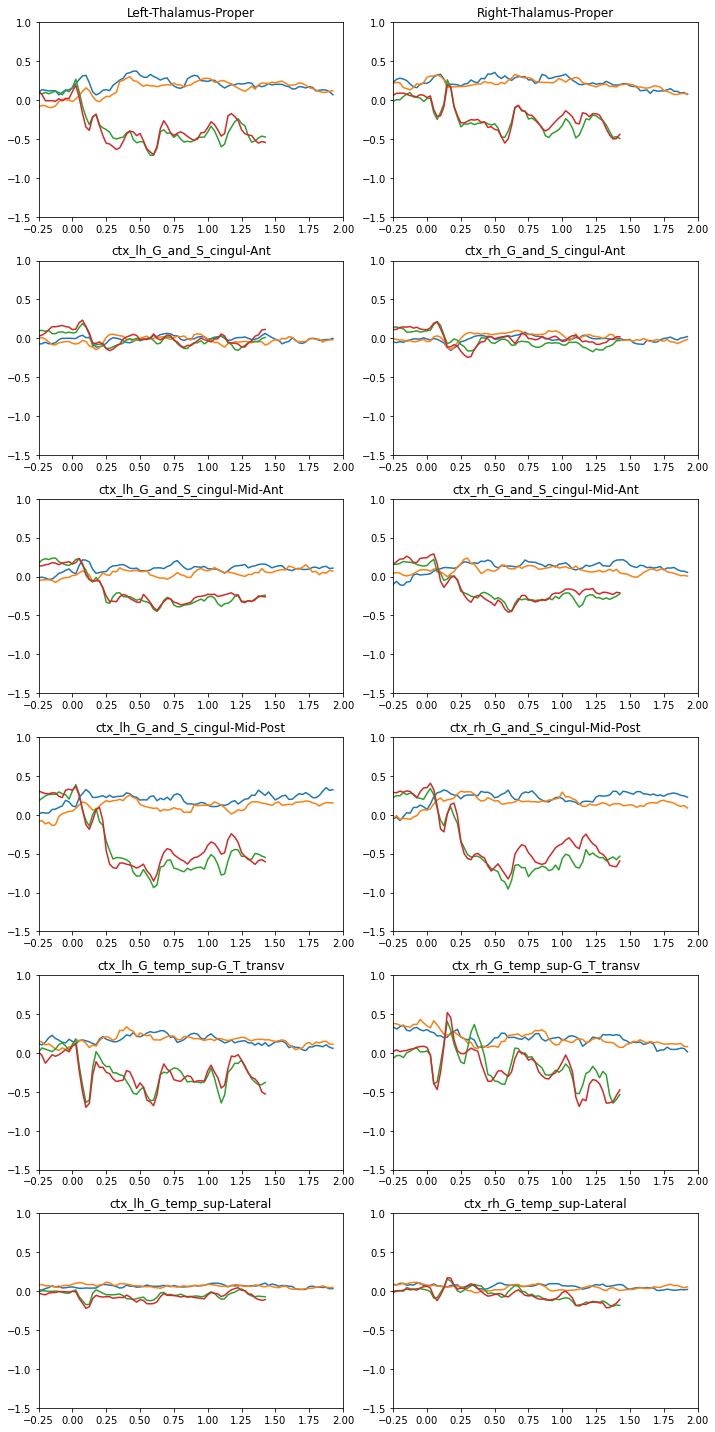

In [20]:
fig, axes = plt.subplots(ncols=2,nrows=6, figsize = (10,20))
for lidx, l in enumerate(stc_labels['main_fmel']):
    rix, cix = lidx//2,lidx%2
    for sl in stc_labels:
        times = grand_avg[sl].times 
        axes[rix,cix].plot(times,stc_labels[sl][lidx])
    axes[rix, cix].set_title(clabels[lidx])
    axes[rix, cix].set_ylim(-1.5,1,5)    
    axes[rix, cix].set_xlim(-.25,2)    
plt.tight_layout()

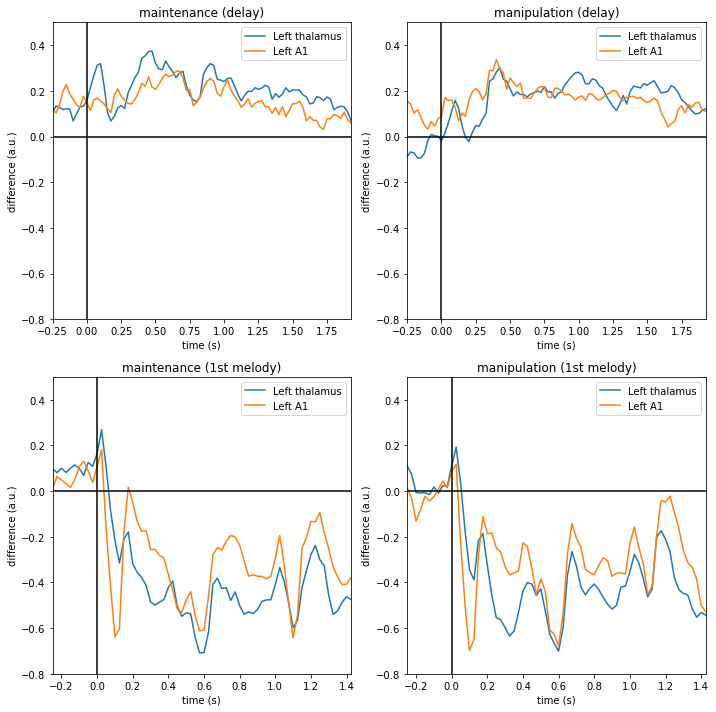

In [18]:
times = grand_avg['main_fmel'].times 
cur_labs = ['Left thalamus','Left A1']
titles = ['maintenance (delay)', 'manipulation (delay)','maintenance (1st melody)','manipulation (1st melody)']
conds = ['inv_fmel','inv_delay']
fig, axes = plt.subplots(ncols=2,nrows=2, figsize = (10,10))
for sidx, sl in enumerate(stc_labels):
    times = grand_avg[sl].times 
    rix, cix = sidx//2,sidx%2
    for lidx in range(len(stc_labels[sl])):
        if lidx in [0,8]:
            axes[rix,cix].plot(times,stc_labels[sl][lidx])
    axes[rix, cix].set_title(titles[sidx])
    axes[rix, cix].set_ylim(-.8,.5)
    axes[rix, cix].set_xlim(times[0],times[-1])
    axes[rix, cix].set_xlabel('time (s)')
    axes[rix, cix].set_ylabel('difference (a.u.)')
    axes[rix, cix].axhline(0., color='k')
    axes[rix, cix].axvline(0., color='k')
    #axes[rix, cix].legend([clabels[cls] for cls in [0,8]])
    axes[rix, cix].legend(cur_labs)
plt.tight_layout()
plt.savefig(figures_dir + 'pattern_sources_labels_lh.pdf',orientation='portrait')

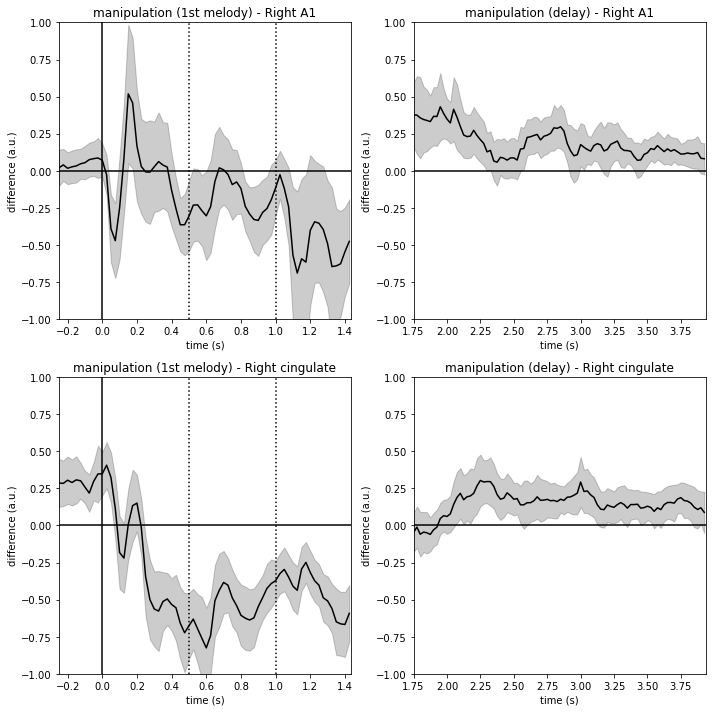

In [32]:
fig, axes = plt.subplots(ncols=2,nrows=2, figsize = (10,10))
cur_labs = ['Right A1','Right cingulate']
lab_ix = [9,7]
conds = ['inv_fmel','inv_delay']
titles = ['manipulation (1st melody)','manipulation (delay)']
sidx = -1
for lx, lab in enumerate(lab_ix):
    lidx = lab_ix[lx]
    for slx, sl in enumerate(conds):
        sidx += 1
        times = grand_avg[sl].times.copy()
        if sl == 'inv_delay':
            times = times + 2 
        rix, cix = sidx//2,sidx%2
        ci_upper = stc_labels[sl][lidx] + 1.96*se_labels[sl][lidx]
        ci_lower = stc_labels[sl][lidx] - 1.96*se_labels[sl][lidx]
        axes[rix, cix].fill_between(times, ci_lower, ci_upper, color='k', alpha=.2)
        axes[rix,cix].plot(times,stc_labels[sl][lidx],color = 'k')
        axes[rix, cix].set_title(titles[slx] + ' - ' + cur_labs[lx])
        axes[rix, cix].set_ylim(-1,1)
        axes[rix, cix].set_xlim(times[0],times[-1]+0.01)
        axes[rix, cix].set_xlabel('time (s)')
        axes[rix, cix].set_ylabel('difference (a.u.)')
        axes[rix, cix].axhline(0., color='k')
        axes[rix, cix].axvline(0., color='k')        
        if sl == 'inv_fmel':
            axes[rix, cix].axvline(.5, color='k',linestyle=':')
            axes[rix, cix].axvline(1, color='k',linestyle=':')
        if sl == 'inv_delay':
            axes[rix, cix].axvline(2, color='k',linestyle='--')
        #axes[rix, cix].legend([clabels[cls] for cls in [1,9]])
        #axes[rix, cix].legend(cur_labs)
plt.tight_layout()
plt.savefig(figures_dir + 'pattern_sources_labels_rh.pdf',orientation='portrait')

In [ ]:
import statsmodels.api as sm

In [ ]:
reg_ix = [0,1,8,9]
ccor = {}
for cd in stc_labels:
    ccor[cd] = {}
    for a1 in reg_ix:
        for a2 in reg_ix:
            if a2 > a1:  
                cur_cmp = clabels[a1] + ' ' + clabels[a2]
                print(cur_cmp)
                ccor[cd][cur_cmp] = np.correlate(stc_labels[cd][a1],
                                                         stc_labels[cd][a2],
                                                         'full')

In [ ]:
lags = np.arange(-len(times)+1,len(times))*0.02
plt.plot(lags,ccor['inv_delay']['Right-Thalamus-Proper ctx_rh_G_temp_sup-G_T_transv'])